In [1]:
%cd /content/drive/My Drive/RV_portfolio

/content/drive/My Drive/RV_portfolio


In [2]:
from backtest import backtest_multiple_period
import datetime
import matplotlib.pyplot as plt
from models import LSTM_RV_PF
import numpy as np
import pandas as pd
import pathlib
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from train import calculate_pv_after_commission, train_rv_pf
from utils.generate_stock_data import generate_mu_sigma, generate_intraday_data
from utils.make_datasets import calculate_realized_volatility, LSTM_RV_PF_Dataset, \
                                make_pf_dataset
%matplotlib inline
ROOT_PATH = pathlib.Path('')

# 0.はじめに


マルチタスク学習によるポートフォリオ最適化アルゴリズムをPyTorchによって実装する．株価の高頻度データを5銘柄分シミュレーションによって発生させ，train/valid/test期間に分割してモデルの訓練・バックテストを行う．モデルはShrap Ratioの向上をメインタスク，ボラティリティの推定をサブタスクとして，weight scalingによって訓練する．バックテストは，2年分のtest期間から開始点を等間隔に選んで，1ヶ月分のテストを175回実施し，Sharp Ratioおよびボラティリティの推定値の平均二乗誤差を記録する．


# 1.データの発生

安全資産が1つ，株式が5銘柄ある市場を考え，株価の日中データを仮想的に発生させる．9時35分から16時00分まで，5分おきに計78回株価を記録する．株価は次のような標準ブラウン運動に従うとする．

$$
dS_t^i=S_t^i(\mu^idt+{}^\top\!\boldsymbol{\sigma}^id{\bf W}_t),\ \ i=1,...,5
$$

ただし，${\bf W}_t={}^\top\!\begin{pmatrix}W_t^1 & \ldots & W_t^5\end{pmatrix}$は5次元標準ブラウン運動で，

$$
\mu^i\in\mathbb{R},\ \ \boldsymbol{\sigma}^i=\begin{pmatrix}\sigma^{1,i}\\ \vdots\\ \sigma^{5,i}\end{pmatrix}
$$

はそれぞれ平均収益率とボラティリティを表す．平均ベクトルとボラティリティ行列を

$$
\boldsymbol{\mu}=\begin{pmatrix}\mu^1\\ \vdots\\ \mu^5\end{pmatrix},\ \ \  \boldsymbol{\sigma}=\begin{pmatrix}\boldsymbol{\sigma}^1 &  \ldots &  \boldsymbol{\sigma}^5\end{pmatrix}=
\begin{pmatrix}\sigma^{1,1} & \ldots & \sigma^{1,5}\\
\vdots & \ddots & \vdots\\
\sigma^{5,1} & \ldots & \sigma^{5,5}\end{pmatrix}
$$

とする．ただし，$\sigma^{i,j}=\sigma^{j,i},\ \ \forall i,j$である． これらを関数```generate_mu_sigma```によって発生させる．

In [3]:
MU_U = 0.001
MU_L = -0.001
SIGMA_U = 0.001
SIGMA_L = -0.001
STOCK_NUM = 5
SEED = 1234
mu, sigma = generate_mu_sigma(MU_U, MU_L, SIGMA_U, SIGMA_L, STOCK_NUM, SEED)
np.set_printoptions(precision=5)
print(f'mu=\n{mu}')
print()
print(f'sigma=\n{sigma}')

mu=
[[-0.00062]
 [ 0.00024]
 [-0.00012]
 [ 0.00057]
 [ 0.00056]]

sigma=
[[ 5.85295e-04 -3.22014e-04 -4.77688e-04  6.78586e-05 -2.19561e-04]
 [-3.22014e-04  7.87124e-04  1.69063e-04  2.04994e-04  7.80826e-05]
 [-4.77688e-04  1.69063e-04  6.69883e-04 -5.97345e-05  2.56949e-04]
 [ 6.78586e-05  2.04994e-04 -5.97345e-05  9.29660e-04 -4.27503e-04]
 [-2.19561e-04  7.80826e-05  2.56949e-04 -4.27503e-04  9.66787e-04]]


```generate_mu_sigma```によって得られた$\boldsymbol{\mu},\boldsymbol{\sigma}$を用いて価格データを発生させる．今回は，株価の初期値を$(S_0^1, …, S_0^5) =(100,150,200,250,300)$とした．


In [4]:
DAY_NUM      = 365 * 12
RECORD_TIMES = 78
DELTA_MINUTES = 5
INITIAL_PRICES = np.array([100,150,200,250,300]).astype(np.float64).reshape(5,1)
DATA_PATH = ROOT_PATH / 'data'
prices_df = generate_intraday_data(mu, sigma, DAY_NUM, RECORD_TIMES, DELTA_MINUTES,
                                   STOCK_NUM, INITIAL_PRICES, 
                                   data_path=DATA_PATH, seed=SEED)

# 2.Realized Volatilityの計算

1.で，1日に78回株価を記録した高頻度データ```prices_df```を擬似的に生成した．次に，株価のリターンを定義する．$t$日の$k$番目の価格を$S_{k,t}$とおく．$t$日目における各時点間の対数階差をとって，$y_{i,t}$を次のように定義する．

$$
\begin{align}
y_{1,t}&=\log S_{2,t}-\log S_{1,t}\\
y_{2,t}&=\log S_{3,t}-\log S_{2,t}\\
&\vdots\\
y_{77,t}&=\log S_{78,t}-\log S_{77,t}\\
\end{align}
$$

この時，$t$日のRealized Volatilityとは

$$
RV_t=\sum_{k=1}^{77}y_{k,t}^2
$$

で定義される．


```calculate_realized_volatility```は```prices_df```をもとにRealized Volatilityを計算する関数である．


In [5]:
CSV_PATH = DATA_PATH / 'random_stock_data.csv'
prices_df = pd.read_csv(CSV_PATH, index_col=0)
prices_df.index = pd.to_datetime(prices_df.index)
prices_open_df, rv_df = calculate_realized_volatility(prices_df, 
                                                      DAY_NUM, RECORD_TIMES, 
                                                      STOCK_NUM)

In [6]:
prices_open_df.head()

,stock1,stock2,stock3,stock4,stock5
2015-01-01 09:35:00,100.128056,149.394791,200.419606,249.535613,299.648456
2015-01-02 09:35:00,101.212498,149.868637,199.271732,257.962225,298.569622
2015-01-03 09:35:00,102.777646,147.101474,203.580070,252.479368,289.884051
2015-01-04 09:35:00,104.000527,146.434387,198.409351,257.042888,270.767836
2015-01-05 09:35:00,106.783778,143.651271,200.908626,254.336851,277.692357


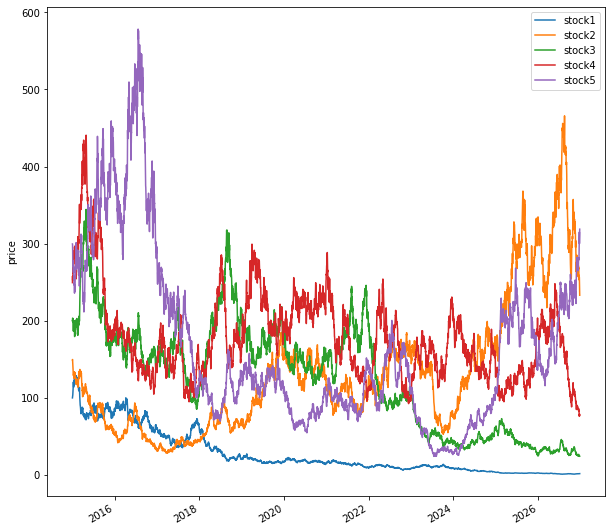

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
prices_open_df.plot(ax=ax)
ax.legend(loc='best')
ax.set_ylabel('price')
plt.show()

In [8]:
rv_df.head()

,stock1,stock2,stock3,stock4,stock5
2015-01-01 09:35:00,0.000447,0.000815,0.000536,0.000851,0.001020
2015-01-02 09:35:00,0.000470,0.000721,0.000613,0.000948,0.000867
2015-01-03 09:35:00,0.000547,0.000674,0.000571,0.000968,0.000896
2015-01-04 09:35:00,0.000472,0.000612,0.000719,0.000832,0.000691
2015-01-05 09:35:00,0.000650,0.000804,0.000739,0.000755,0.000856


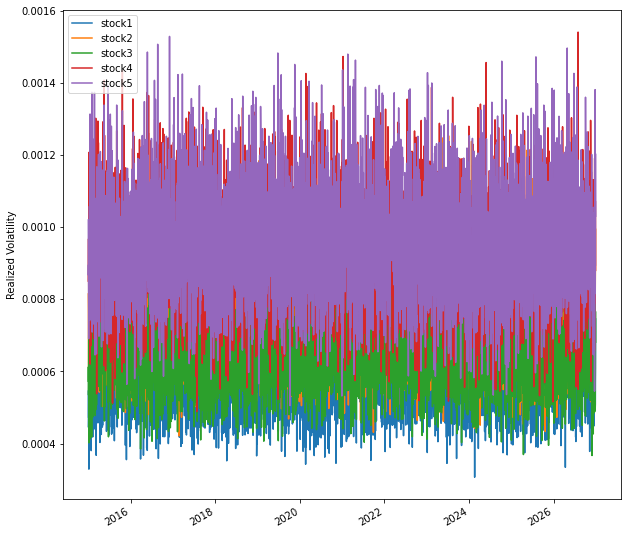

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
rv_df.plot(ax=ax)
ax.legend(loc='best')
ax.set_ylabel('Realized Volatility')
plt.show()

# 3.モデルの定義



```LSTM_RV_PF```モデルは次のような構造を取る．特徴抽出器にはLSTMを使用した．

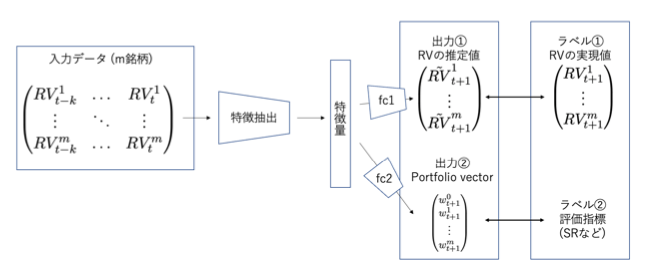

In [10]:
from IPython.display import Image, display_png
IMG_PATH = ROOT_PATH / 'img'
display_png(Image(str(IMG_PATH / 'multitask_model.png')))

In [11]:
model = LSTM_RV_PF(5, 124, 5)

# 4.Datasetの定義

```make_pf_dataset```関数で，```prices_open_df```や```rv_df```をPyTorchのDatasetへと加工する．

In [12]:
TRAIN_YEARS = [2015, 2016, 2017, 2018, 2019]
VALID_YEARS = [2020, 2021, 2022, 2023, 2024]
INPUT_LENGTH = 4
train_dataset, valid_dataset = make_pf_dataset(prices_open_df, rv_df,
                                               TRAIN_YEARS, VALID_YEARS, 
                                               INPUT_LENGTH)

# 4.訓練

```train_rv_pf```によって，モデルの訓練を行う．```model```はポートフォリオベクトル```w```と，一期先のボラティリティの予測値```rv_pred```を出力する．それぞれの出力値をもとにSharp RatioとRealized Volatilityの平均二乗誤差の重み付き和を損失関数として勾配降下法を実施する．```lam1```がSharp Ratioにかかる重みで，```lam2```が平均二乗誤差にかかる重みである．


device:cpu
episode1/100 [Sharp Ratio]tra:-0.0013 val:0.0006 [RV loss]tra:0.00604017 val:0.00235419
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode2/100 [Sharp Ratio]tra:0.0007 val:0.0010 [RV loss]tra:0.00164711 val:0.00063764
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode3/100 [Sharp Ratio]tra:0.0029 val:0.0013 [RV loss]tra:0.00030988 val:0.00028576
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode4/100 [Sharp Ratio]tra:0.0049 val:0.0019 [RV loss]tra:0.00025256 val:0.00021616
model saving to >> checkpoints/lstm_rv_pf_best.tar
episode5/100 [Sharp Ratio]tra:0.0057 val:0.0019 [RV loss]tra:0.00011460 val:0.00004315
model saving to >> checkpoints/lstm_rv_pf_best.tar
model saving to >> checkpoints/lstm_rv_pf_last.tar
model saving to >> checkpoints/lstm_rv_pf_last.tar
model saving to >> checkpoints/lstm_rv_pf_last.tar
model saving to >> checkpoints/lstm_rv_pf_last.tar
episode10/100 [Sharp Ratio]tra:0.0078 val:0.0018 [RV loss]tra:0.00003239 val:0.00000750
model 

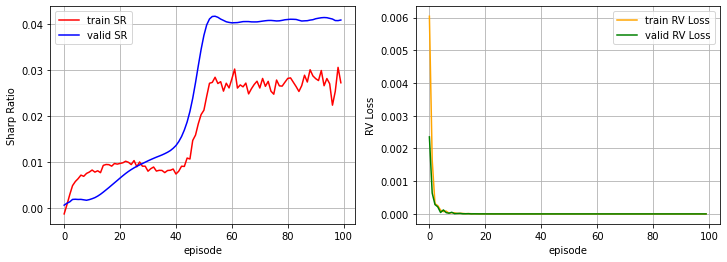

In [18]:
model = LSTM_RV_PF(5, 124, 5)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INITIAL_PV = 1
LAM1 = 1
LAM2 = 0.2
LAM3 = 1e-02
LOSS_INTERVAL = 500
BEST_SAVE_PATH = ROOT_PATH / 'checkpoints' / 'lstm_rv_pf_best.tar'
LAST_SAVE_PATH = ROOT_PATH / 'checkpoints' / 'lstm_rv_pf_last.tar'
NUM_EPISODE = 100
COMMISSION_RATE = 0.00
model = train_rv_pf(model, DEVICE, INITIAL_PV,
                    LAM1, LAM2, LAM3, LOSS_INTERVAL,
                    train_dataset, valid_dataset,
                    BEST_SAVE_PATH, LAST_SAVE_PATH, 
                    NUM_EPISODE, COMMISSION_RATE, SEED)

train/valid共に，平均二乗誤差が小さく，Sharp Ratioが大きくなる方向に学習できている．

# 5.テスト

```backtest_multiple_period```により，2025,2026年のデータを利用して訓練済みモデルのテストを行う．1月1日から4日ごとにテストの開始時点を設定し，開始時点から1ヶ月間のバックテストによってSharp RatioおよびRealized Volatilityの推定値の平均二乗誤差を保存する．

In [23]:
test_dates = []
TEST_YEARS = [2025,2026]
for date in prices_open_df.index:
    if date.year in TEST_YEARS:
        test_dates.append(date)
PERIOD_LENGTH = 30
INTERVAL = 4
model = LSTM_RV_PF(5, 124, 5)
checkpoint = torch.load(BEST_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])

test_df = backtest_multiple_period(model, DEVICE, INITIAL_PV, 
                                   prices_open_df, rv_df,
                                   INPUT_LENGTH, test_dates, COMMISSION_RATE,
                                   PERIOD_LENGTH, INTERVAL, DATA_PATH)

In [24]:
test_df.head()

,start date,end date,Sharp Ratio,RV Loss
0,2025-01-01 09:35:00,2025-01-31 09:35:00,0.219352,2.049166e-08
1,2025-01-05 09:35:00,2025-02-04 09:35:00,0.113100,2.107612e-08
2,2025-01-09 09:35:00,2025-02-08 09:35:00,0.204368,2.062311e-08
3,2025-01-13 09:35:00,2025-02-12 09:35:00,0.142706,2.075141e-08
4,2025-01-17 09:35:00,2025-02-16 09:35:00,0.278904,1.976641e-08


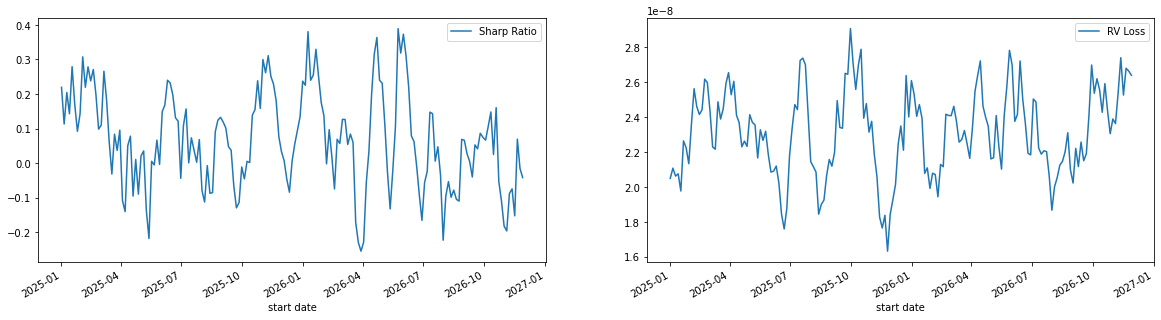

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
test_df.plot(x='start date', y='Sharp Ratio', ax=axes[0], legend=True)
test_df.plot(x='start date', y='RV Loss', ax=axes[1], legend=True)

In [26]:
corr_SR_RV_loss = test_df.corr()
print('Correlation between RV Loss and Sharp Ratio')
corr_SR_RV_loss

Correlation between RV Loss and Sharp Ratio


,Sharp Ratio,RV Loss
Sharp Ratio,1.00000,0.02006
RV Loss,0.02006,1.00000


# 6.今後について

- 今回はシミュレーションデータを利用したため，データがボラティリティ・クラスタリングやレバレッジ効果といった，ボラティリティ予測の重要な手がかりになりうる性質を持っていない．次回は実際の株式市場の高頻度データを利用して実験する．
- 他のアルゴリズムも実装して提案手法との比較を行う．
